In [53]:
import requests
import numpy as np
import json
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats.stats import pearsonr
import scipy as sp
from scipy import stats
from scipy.stats import skew,norm
from sklearn.preprocessing import PolynomialFeatures
plt.style.use('seaborn')


In [2]:
df = pd.read_csv("AB_NYC_2019.csv")  #Loading in the csv file into a Pandas Data Frame

In [3]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


## Data Cleaning

In [4]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [5]:
df["last_review"].dropna(inplace = True)  #removing all null values
df.shape

(48895, 16)

In [6]:
df.isnull().sum()  #checking to see if the data frame was reduced in size after dropping the NaN values

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [7]:
df.drop(columns= ['id','name','host_name','last_review'], inplace= True)
df.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [8]:
df.fillna({'reviews_per_month':0}, inplace=True)

In [9]:
df.isnull().sum()

host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

## Feature Engineering

In [10]:
location_coord = list(zip(df.latitude, df.longitude))

In [11]:
df['coordinates']= location_coord

How far is each airbnb from NYC's top attraction Times Square?

In [12]:
times_square_geo= [40.7559, -73.9871]

In [13]:
from geopy.distance import distance
df['dist_from_TS']= df.coordinates.apply(lambda x: distance(x, times_square_geo).miles)

In [14]:
df["neighbourhood_group"].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [15]:
df["neighbourhood"].value_counts()

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
New Dorp                 1
Richmondtown             1
Rossville                1
Woodrow                  1
Fort Wadsworth           1
Name: neighbourhood, Length: 221, dtype: int64

In [16]:
df.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,coordinates,dist_from_TS
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,"(40.647490000000005, -73.97237)",7.520408
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,"(40.75362, -73.98376999999999)",0.235124
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,"(40.809020000000004, -73.9419)",4.365322
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,"(40.685140000000004, -73.95976)",5.089206
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,"(40.79851, -73.94399)",3.709244


In [17]:
#sns.pairplot(df)

In [18]:
df_corr_matrix = df.corr() 
df_corr_matrix  #computed a correlation matrix for data set to see if it suggested that any features were collinear

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,dist_from_TS
host_id,1.000000,0.020224,0.127055,0.015309,-0.017364,-0.140106,0.209783,0.154950,0.203492,0.095536
latitude,0.020224,1.000000,0.084788,0.033939,0.024869,-0.015389,-0.018758,0.019517,-0.010983,-0.376930
longitude,0.127055,0.084788,1.000000,-0.150019,-0.062747,0.059094,0.138516,-0.114713,0.082731,0.555624
price,0.015309,0.033939,-0.150019,1.000000,0.042799,-0.047954,-0.050564,0.057472,0.081829,-0.175187
minimum_nights,-0.017364,0.024869,-0.062747,0.042799,1.000000,-0.080116,-0.124905,0.127960,0.144303,-0.076280
number_of_reviews,-0.140106,-0.015389,0.059094,-0.047954,-0.080116,1.000000,0.589407,-0.072376,0.172028,0.059899
reviews_per_month,0.209783,-0.018758,0.138516,-0.050564,-0.124905,0.589407,1.000000,-0.047312,0.163732,0.117856
calculated_host_listings_count,0.154950,0.019517,-0.114713,0.057472,0.127960,-0.072376,-0.047312,1.000000,0.225701,-0.120616
availability_365,0.203492,-0.010983,0.082731,0.081829,0.144303,0.172028,0.163732,0.225701,1.000000,0.088723
dist_from_TS,0.095536,-0.376930,0.555624,-0.175187,-0.076280,0.059899,0.117856,-0.120616,0.088723,1.000000


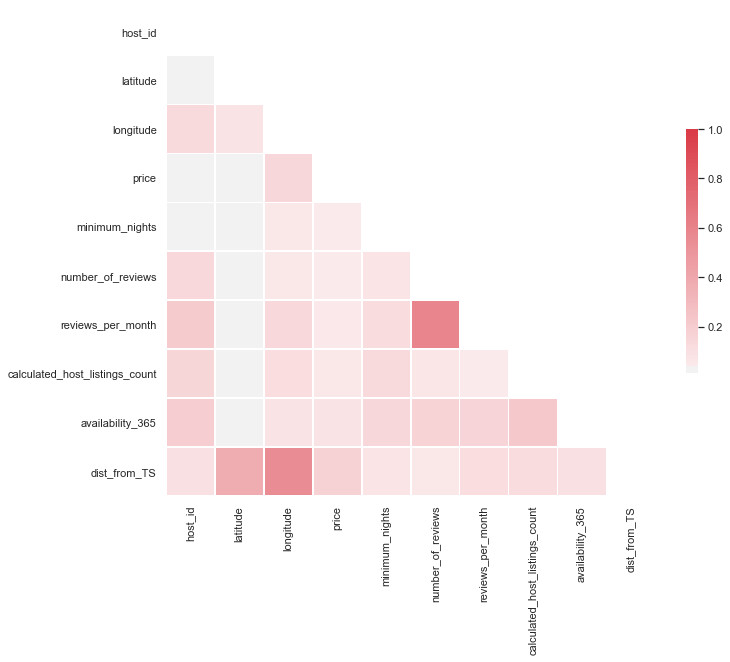

In [19]:
sns.set(style="white")  #using a heat map to display the visuals for the correlations in the dataset
# Compute the correlation matrix
corr = np.abs(df.corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

In [20]:
df['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [21]:
#Getting rid of outliers of price from both low end (under $25) and high end (above $300)
df = df[df["price"]<300]
df = df[df["price"]>25]
df['price'].describe()

count    44748.000000
mean       116.506816
std         62.882545
min         26.000000
25%         65.000000
50%        100.000000
75%        150.000000
max        299.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Price & Neighbourhood Group')

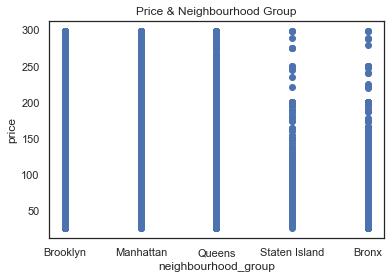

In [22]:
plt.scatter(df['neighbourhood_group'], df['price'])
plt.xlabel('neighbourhood_group')
plt.ylabel('price')
plt.title('Price & Neighbourhood Group')

Text(0.5, 1.0, 'Price & Neighbourhood')

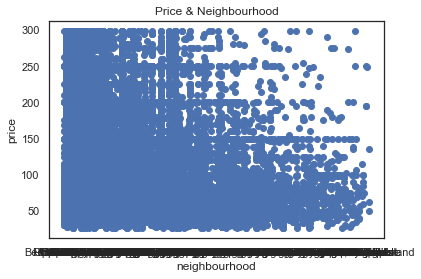

In [23]:
plt.scatter(df['neighbourhood'], df['price'])
plt.xlabel('neighbourhood')
plt.ylabel('price')
plt.title('Price & Neighbourhood')

Text(0.5, 1.0, 'Price & Room Type')

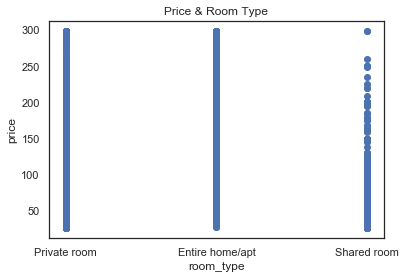

In [24]:
plt.scatter(df['room_type'], df['price'])
plt.xlabel('room_type')
plt.ylabel('price')
plt.title('Price & Room Type')

Text(0.5, 1.0, 'Price & Number of Reviews')

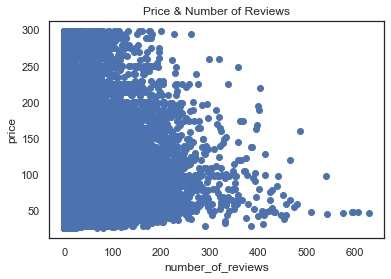

In [25]:
plt.scatter(df['number_of_reviews'], df['price'])
plt.xlabel('number_of_reviews')
plt.ylabel('price')
plt.title('Price & Number of Reviews')

Text(0.5, 1.0, 'Price & Review Per Month')

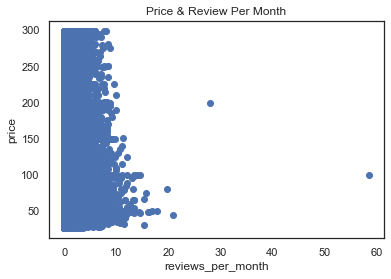

In [26]:
plt.scatter(df['reviews_per_month'], df['price'])
plt.xlabel('reviews_per_month')
plt.ylabel('price')
plt.title('Price & Review Per Month')

In [27]:
#sns.distplot(df.price).set_title('AirBnB') #checked to see the skewness of target variable of price


In [28]:
df.sort_values("price", ascending = False)


,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,coordinates,dist_from_TS
6520,24429897,Manhattan,West Village,40.73552,-74.00521,Entire home/apt,299,5,0,0.00,1,0,"(40.73552, -74.00520999999999)",1.697315
45113,232596712,Manhattan,Upper West Side,40.77728,-73.98062,Entire home/apt,299,30,0,0.00,6,365,"(40.77728, -73.98062)",1.513945
41079,224414117,Manhattan,Hell's Kitchen,40.75490,-73.99679,Private room,299,1,0,0.00,30,363,"(40.7549, -73.99679)",0.513114
41080,224414117,Manhattan,Hell's Kitchen,40.75628,-73.99643,Private room,299,1,0,0.00,30,365,"(40.75628, -73.99643)",0.490260
28287,95459395,Manhattan,Hell's Kitchen,40.76084,-73.99899,Entire home/apt,299,30,0,0.00,18,365,"(40.76084, -73.99899)",0.710916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30357,111782745,Brooklyn,Williamsburg,40.70477,-73.93206,Shared room,26,2,8,0.48,2,0,"(40.70477, -73.93205999999999)",4.560109
21226,2092314,Brooklyn,East Flatbush,40.65024,-73.95051,Shared room,26,30,2,0.09,7,365,"(40.650240000000004, -73.95051)",7.539711
27710,17906387,Brooklyn,Bushwick,40.69668,-73.91395,Private room,26,4,1,0.05,1,0,"(40.69668, -73.91395)",5.607461
43394,224150,Brooklyn,Midwood,40.61489,-73.94541,Shared room,26,2,5,1.83,1,0,"(40.61489, -73.94541)",9.973343


In [29]:
#bins = [1, 211, 420, 629]  #defining bins


In [30]:
#review_bin_rating = ["Low", "Average", "High"]  #labeling the bins


In [31]:
#df["Review Rating"] = pd.cut(df["number_of_reviews"], bins, labels = review_bin_rating) #making a new column with binned values


In [32]:
neighbourhood_g = pd.get_dummies(df.neighbourhood_group).iloc[:, 1:]  #creating dummies for categorical variables
room_t = pd.get_dummies(df.room_type).iloc[:, 1:]

df = pd.concat([df, neighbourhood_g, room_t], axis = 1)  #concatting dummies into original Data Frame

In [33]:
#df_under500.rename(columns = {"neighbourhood_group": "Neighborhood Group", "room_type": "Room Type", "number_of_reviews": "Number_of_Reviews"}, inplace = True)
#df_under500.head() #renamed columns to display better on axis



In [34]:
#figure,ax = plt.subplots(figsize=(10,10))  #boxplot of price & neighborhood groups
#sns.boxplot(x = "Neighborhood Group", y = "price", data = df2).set_title("AirBnb")
#plt.savefig('Box_NGroup.png')

Shows that price is influenced by the borough the Airbnb is located in; Manhattan having the highest average of price.


In [35]:
#figure,ax = plt.subplots(figsize=(10,10))  #bar graph of price & room types
#sns.barplot(x = "Room Type", y = "price", data = df2).set_title("AirBnb")
#plt.savefig('Bar_Room.png')

Shows that Entire home/apt room type offers the highest price


## Data Visualization

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

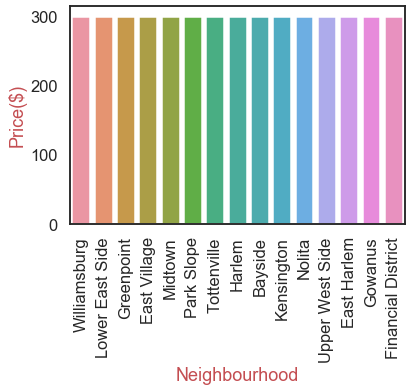

In [36]:
sns.set_context("talk",font_scale=1.0)
ax=sns.barplot('neighbourhood','price',data = df.nlargest(20,'price'),ci=None)
plt.xlabel("Neighbourhood",color='r')
plt.ylabel("Price($)",color='r')
plt.xticks(rotation=90)

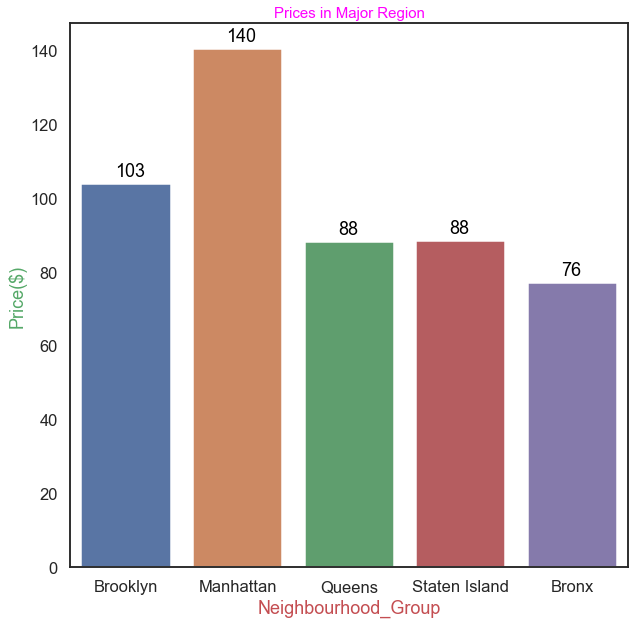

In [37]:
figure,ax = plt.subplots(figsize=(10,10))
sns.set_context('talk')
ax=sns.barplot(x = df['neighbourhood_group'],y = df['price'],ci=None)
plt.xlabel("Neighbourhood_Group",color='r')
plt.ylabel("Price($)",color='g')
plt.title("Prices in Major Region",color='magenta',size=15)

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.30, p.get_height()+1), va='bottom',
                    color= 'black')

- Shows that price is influenced by the borough the Airbnb is located in; Manhattan having the highest average of price.


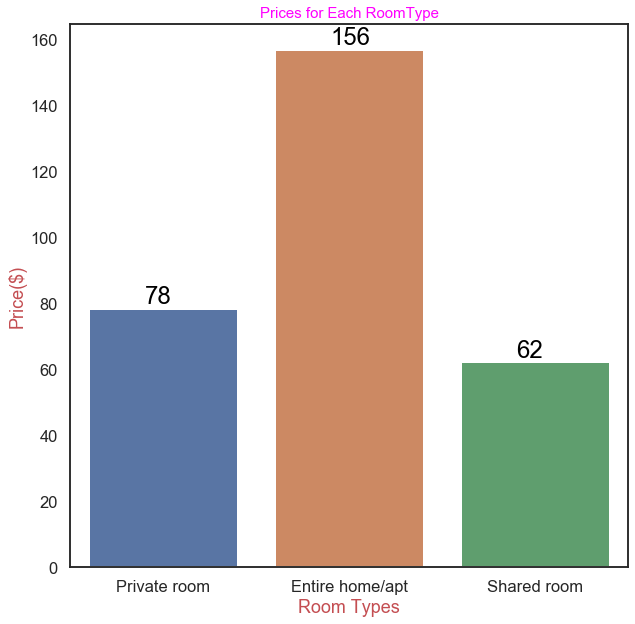

In [38]:
figure,ax = plt.subplots(figsize=(10,10))
sns.set_context('poster')
ax = sns.barplot(df['room_type'],df['price'],ci=None)
plt.xlabel("Room Types",color='r')
plt.ylabel("Price($)",color='r')
plt.title("Prices for Each RoomType",color='magenta',size=15)

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.30, p.get_height()-0.05), va='bottom',
                    color= 'black')

- Shows that price is influenced by the type of room in the Airbnb (whether a shared or private room/Entire home). Renting an Entire home has the highest price

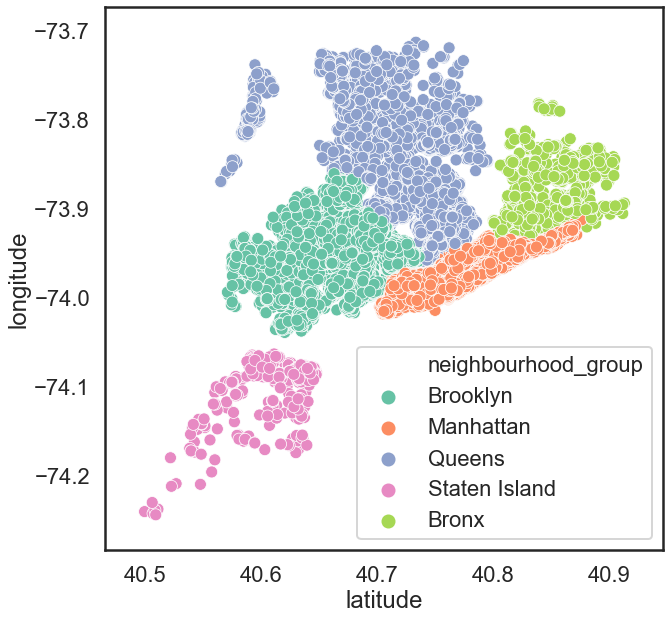

In [39]:
figure,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=df['latitude'],y=df['longitude'],hue=df['neighbourhood_group'],data=df,palette='Set2')

- Outlining the coordinates of different boroughs

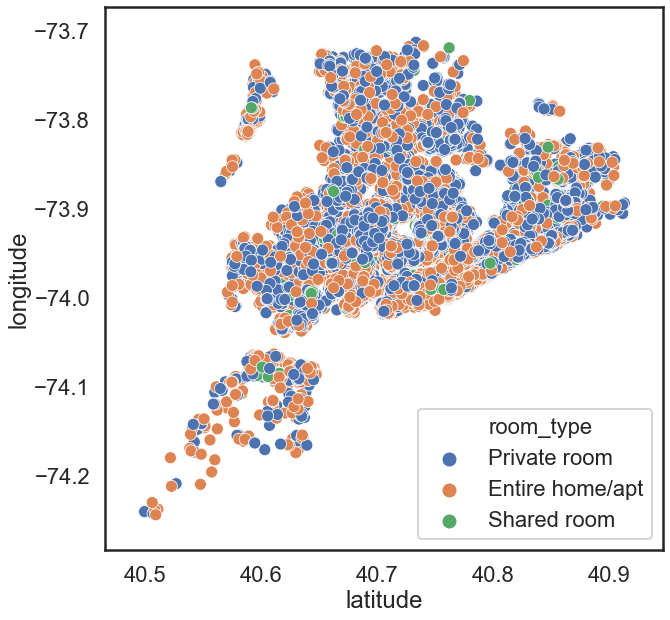

In [40]:
figure,ax = plt.subplots(figsize=(10,10))
sns.set_style('white')
sns.scatterplot(x=df['latitude'],y=df['longitude'],hue=df['room_type'],data=df,sizes='size',
               markers="markers")

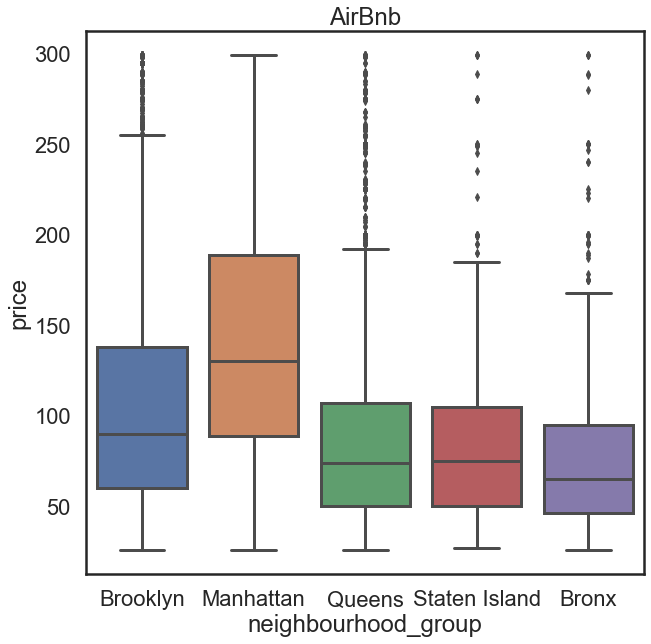

In [41]:

figure,ax = plt.subplots(figsize=(10,10))  #boxplot of price & neighborhood groups
sns.boxplot(x = "neighbourhood_group", y = "price", data = df).set_title("AirBnb")
plt.savefig('Box_NGroup.png')

Shows that price is influenced by the borough the Airbnb is located in; Manhattan having the highest average of price.



NameError: name 'df2' is not defined

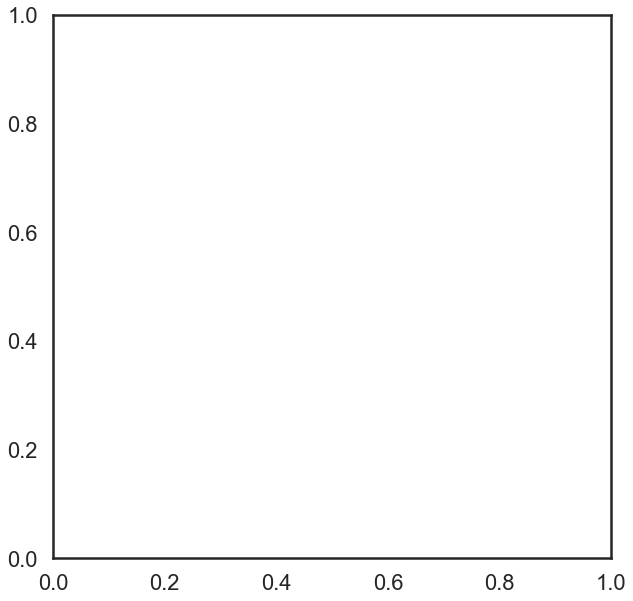

In [42]:
figure,ax = plt.subplots(figsize=(10,10))  #bar graph of price & room types
sns.barplot(x = "room_type", y = "price", data = df2).set_title("AirBnb")
plt.savefig('Bar_Room.png')

Shows that Entire home/apt room type offers the highest price



In [ ]:
figure,ax = plt.subplots(figsize=(10,6))
sns.catplot(x="neighbourhood_group", kind = "count", data = df)
plt.show()


- Shows that price is influenced by the borough the Airbnb is located in; Manhattan having the highest average of price.

# Hypothesis Testing

In [ ]:
from scipy import stats

In [ ]:
df.head()

### 1. Anova Test

- H0: There is no difference between the means of price and the neighborhood groups 
- HA: There is a difference between the means of price and the neighborhood groups
- Conclusion: Based on the P-Value, I can reject the null hypothesis



In [ ]:
stats.f_oneway(df["price"][df['neighbourhood_group'] == 'Manhattan'],
                df['price'][df['neighbourhood_group'] == 'Brooklyn'], 
                df['price'][df['neighbourhood_group'] == 'Queens'])

### 2. Anova Test


- H0: There is no difference between the means of price and the room types 
- HA: There is a difference between the means of price and the room types
- Conclusion: Based on the P-Value, I can reject the null hypothesis

In [ ]:
stats.f_oneway(df["price"][df['room_type'] == 'Entire home/apt'],
                df['price'][df['room_type'] == 'Private room'], 
                df['price'][df['room_type'] == 'Shared room'])

### Was going to add another Anova test - debating

In [ ]:
#stats.f_oneway(df['price'][df['Review Rating'] == 'Low'],
#                df['price'][df['Review Rating'] == 'Average'], 
#                df['price'][df['Review Rating'] == 'Good'])

### 3. Two Sample T-Test of means comparing the price of a private room and shared room

In [ ]:
df.room_type.unique()

In [ ]:
from scipy import stats
private = df[df['room_type'] == 'Private room']
shared = df[df['room_type'] == 'Shared room']
stats.ttest_ind(private['price'], shared['price'])

- Number of reviews and price - one sample t test

# Initial Regression/ Modeling


In [56]:
subset = xregress
df_features = df[subset]
target = df['points']
def linear_regression(df_features,target):
    lm = LinearRegression()
    lm = lm.fit(df_features,target)
    X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state = 34, test_size=0.2)#
    lm = LinearRegression()
    lm = lm.fit(X_train, y_train)
    y_train_pred = lm.predict(X_train)
    mae = metrics.mean_absolute_error(y_train, y_train_pred)
    mse = metrics.mean_squared_error(y_train, y_train_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    y_test_pred = lm.predict(X_test)
    mae2 = metrics.mean_absolute_error(y_test, y_test_pred)
    mse2 = metrics.mean_squared_error(y_test, y_test_pred)
    rmse2 = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    print(lm.intercept_)
    print(lm.coef_)
    print('R^2', lm.score(df_features, target))
    print('Training Mean Absolute Error:', mae )
    print('Training Mean Squared Error:',  mse)
    print('Training Root Mean Squared Error:' , rmse)
    print('Testing Mean Absolute Error:', mae2 )
    print('Testing Mean Squared Error:',  mse2)
    print('Testing Root Mean Squared Error:' , rmse)
linear_regression(df_features,target)

NameError: name 'xregress' is not defined

In [55]:
test_train(df)

ValueError: could not convert string to float: 'Manhattan'

In [47]:
df_features = df.drop(columns= ['price'])
target = df['price']

In [48]:
## training the model
from sklearn.linear_model import Lasso
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=34,test_size=0.3)
lasso = Lasso(alpha=0.01, normalize=True)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training RMSE: '+ str(train_rmse) )
print('Testing RMSE: '+ str(test_rmse) )

NameError: name 'train_test_split' is not defined

In [57]:
mlr_model = ols(formula = "price ~ neighbourhood_group + neighbourhood + latitude + longitude + room_type + minimum_nights + number_of_reviews + reviews_per_month, calculated_host_listings_count + availability_365", data = df).fit()  #Without scaling the numbers
mlr_model.summary()  #output of all my features that came with dataset




In [60]:
df.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,coordinates,dist_from_TS,Brooklyn,Manhattan,Queens,Staten Island,Private room,Shared room
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,"(40.647490000000005, -73.97237)",7.520408,1,0,0,0,1,0
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,"(40.75362, -73.98376999999999)",0.235124,0,1,0,0,0,0
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,"(40.809020000000004, -73.9419)",4.365322,0,1,0,0,1,0
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,"(40.685140000000004, -73.95976)",5.089206,1,0,0,0,0,0
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,"(40.79851, -73.94399)",3.709244,0,1,0,0,0,0


In [62]:
mlr_model = ols(formula = "price ~ neighbourhood_group + latitude + longitude + room_type + number_of_reviews ", data = df).fit()  #Without scaling the numbers
mlr_model.summary()  #removed some features based on coefficients and p-vlaues



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     4573.
Date:                Thu, 30 Jul 2020   Prob (F-statistic):               0.00
Time:                        00:44:12   Log-Likelihood:            -2.3421e+05
No. Observations:               44748   AIC:                         4.684e+05
Df Residuals:                   44738   BIC:                         4.685e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                            -1.405e+04    651.042    -21.574      0.000   -1.53e+04   -1.28e+04
neighbourhood_group[T.Brooklyn]        -13.1255      1.784     -7.357      0.000     -16.622      -9.629
neighbourhood_group[T.Manhattan]        17.7643      1.617     10.988      0.000      14.596      20.933
neighbourhood_group[T.Queens]            1.5954      1.716      0.930      0.353      -1.768       4.959
neighbourhood_group[T.Staten Island]   -73.7865      3.402    -21.689      0.000     -80.454     -67.118
room_type[T.Private room]              -71.3283      0.444   -160.666      0.000     -72.198     -70.458
room_type[T.Shared room]               -91.2058      1.455    -62.684      0.000     -94.058     -88.354
latitude                               -94.1793      6.411    -14.691      0.000    -106.745     -81.614
longitude                             -243.8624      7.324    -33.296      0.000    -258.218    -229.507
number_of_reviews                       -0.0098      0.005     -2.077      0.038      -0.019      -0.001
==============================================================================
Omnibus:                     5623.445   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8913.076
Skew:                           0.890   Prob(JB):                         0.00
Kurtosis:                       4.269   Cond. No.                     2.70e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
mlr_model = ols(formula = "price ~ neighbourhood_group + neighbourhood + latitude + longitude + room_type + minimum_nights + number_of_reviews + last_review + reviews_per_month + calculated_host_listings_count + availability_365", data = df).fit()  #Without scaling the numbers
mlr_model.summary()  #output of all my features that came with dataset

PatsyError: Error evaluating factor: NameError: name 'last_review' is not defined
    price ~ neighbourhood_group + neighbourhood + latitude + longitude + room_type + minimum_nights + number_of_reviews + last_review + reviews_per_month + calculated_host_listings_count + availability_365
                                                                                                                          ^^^^^^^^^^^